In [58]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from matcher import Dinov2Matcher
from utils.spd import read_pointcloud
from utils.geometric_vision import solve_pnp_ransac
from torchvision import transforms
import matplotlib.pyplot as plt
from utils.spd import depth_map_to_pointcloud
from utils.spd import  transform_pointcloud

In [39]:
from ref_dataset import ReferenceDataset, SimTestDataset
vis_dataset = SimTestDataset(features=True)
ref_dataset = ReferenceDataset(dataset_location="/root/autodl-tmp/shiqian/code/gripper/render_lowres", num_views=840,features=True)
ref_dataloader = DataLoader(ref_dataset, batch_size=1, shuffle=False)
refs = next(iter(ref_dataloader))
vis_dataloader = DataLoader(vis_dataset, batch_size=1, shuffle=False)
iterloader = iter(vis_dataloader)

Loading reference view dataset...
Found 64 views in /root/autodl-tmp/shiqian/code/gripper/render_random
Loading reference view dataset...
Found 840 views in /root/autodl-tmp/shiqian/code/gripper/render_lowres


Initializing DinoV2 Matcher...
Preprocessing reference views...
Reference view features obtained
DinoV2 Matcher done initialized
depth_maps torch.Size([840, 180, 320])
depths torch.Size([3796])
c2os: torch.Size([3796, 4, 4])
torch.Size([3796, 3])
torch.Size([122, 6])
gt_cam_to_obj: [[-0.88547952  0.41707137  0.20488405 -0.20488401]
 [-0.03305243  0.38326792 -0.92304564  0.9230456 ]
 [-0.46350138 -0.82410991 -0.32559071  0.32559073]
 [ 0.          0.          0.          1.        ]]


(-0.5, 319.5, 179.5, -0.5)

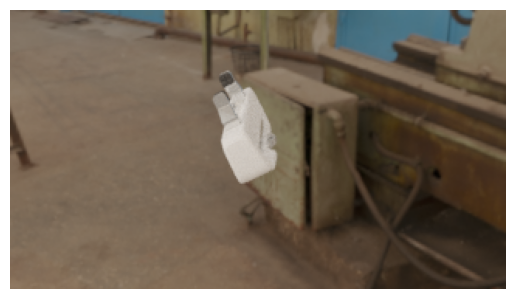

In [66]:
# code from match.run_model

d = next(iterloader)
gripper_pointcloud = read_pointcloud("./pointclouds/gripper.txt")
device = 'cuda:0'
matcher = Dinov2Matcher(refs=refs, model_pointcloud=gripper_pointcloud, device=device)

rgbs = torch.Tensor(d['rgb']).float().permute(0, 3, 1, 2).to(device) # B, C, H, W
depths = torch.Tensor(d['depth']).float().permute(0, 3, 1, 2).to(device)
masks = torch.Tensor(d['mask']).float().permute(0, 3, 1, 2).to(device)
c2ws = d['c2w'] # B, 4, 4
o2ws = d['obj_pose'] # B, 4, 4
intrinsics = d['intrinsics']
matches_3d = matcher.match_and_fuse(d)     # N, 6

test_camera_K = np.zeros((3,3))
test_camera_K[0,0] = intrinsics['fx']
test_camera_K[1,1] = intrinsics['fy']
test_camera_K[0,2] = intrinsics['cx']
test_camera_K[1,2] = intrinsics['cy']
test_camera_K[2,2] = 1
gt_pose = np.dot(np.linalg.inv(o2ws[0]), c2ws[0])
print("gt_cam_to_obj:", gt_pose)

matches_3d[:,[1,2]] = matches_3d[:,[2,1]]
pnp_retval, translation, rt_matrix = solve_pnp_ransac(matches_3d[:,3:6].cpu().numpy(), matches_3d[:,1:3].cpu().numpy(), camera_K=test_camera_K)

test_pointcloud_cam = depth_map_to_pointcloud(depths[0,0], masks[0,0], intrinsics)
test_pointcloud_cam2obj = transform_pointcloud(test_pointcloud_cam, np.linalg.inv(rt_matrix))
test_pointcloud_obj2cam = transform_pointcloud(gripper_pointcloud, rt_matrix)

fig = plt.figure()
plt.subplot(1,1, 1)
plt.imshow(np.array((rgbs[0].permute(1,2,0)/255.0).cpu()))
plt.axis('off')

In [67]:
print(test_pointcloud_cam.shape)     # 由深度图算出的实际位置
print(test_pointcloud_cam2obj.shape) # 不知道是啥
print(test_pointcloud_obj2cam.shape) # 预测位置

(1792, 3)
(1792, 3)
(8192, 3)


In [81]:
import plotly.graph_objects as go

point_cloud = np.concatenate((test_pointcloud_cam,test_pointcloud_obj2cam),axis=0)
point_color = np.zeros((1792+8192,3),dtype=float)
point_color[:1792] = np.array([1,0,0])
point_color[1792:1792+8192] = np.array([0,0,1])
point_color[1792+8192:] = np.array([0,1,0])
fig = go.Figure(data=[go.Scatter3d(
    x=point_cloud[:, 0],
    y=point_cloud[:, 1],
    z=point_cloud[:, 2],
    mode='markers',
    marker=dict(
        size=5,  # 调整节点的大小
        color=point_color,  # 给点云上色
        opacity=0.9
    )
)])
fig.update_layout(width=1000, height=1000)
fig.update_scenes(aspectmode='data')
fig.show()

torch.Size([122, 6])


(-0.5, 319.5, 179.5, -0.5)

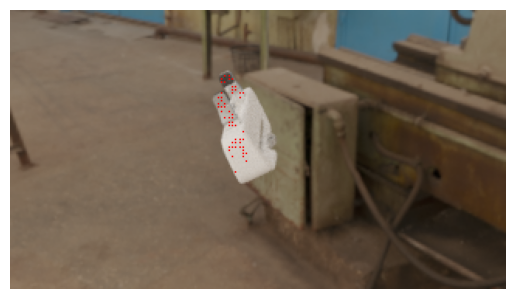

In [120]:
# match_3d中，选的关键点的实际位置
fig = plt.figure()
plt.subplot(1,1, 1)
print(matches_3d.shape)
image = np.array((rgbs[0].permute(1,2,0)/255.0).cpu())
for i_match in range(matches_3d.shape[0]):
    y,x = int(matches_3d[i_match,1].cpu().numpy()), int(matches_3d[i_match,2].cpu().numpy())
    image[x,y] = [1,0,0]
plt.imshow(image)
plt.axis('off')

(8192, 3)


(-0.5, 319.5, 179.5, -0.5)

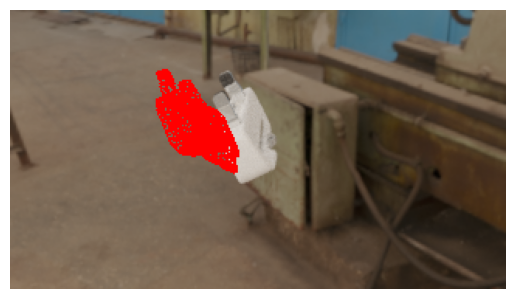

In [119]:
# 把预测出来的3d点云投影回2d上

project_point = test_pointcloud_obj2cam
print(project_point.shape)
project_2d = np.dot(test_camera_K,np.array(project_point.transpose(1,0))).transpose(1,0)[:,:2]
# print(project_2d)
image = np.array((rgbs[0].permute(1,2,0)/255.0).cpu())
for i in range(project_2d.shape[0]):
    y,x = int(project_2d[i,0]), int(project_2d[i,1])
    image[x,y] = [1,0,0]

plt.subplot(1,1, 1)
plt.imshow(image)
plt.axis('off')